![logo](../img/cems_header.png)

<br>

# Observing major flood events with GLOFAS

## About

This tutorial will demonstrate how to investigate a specific flood event using data from the Global Flood
Awareness Service (GloFAS). For this example we look at the June 2022 flooding in Bangladesh.

The GLOFAS data is produced operationally by ECMWF for the Copernicus Emergency Management Service (CEMS).

The tutorial will first show how to download the necessary data from the C3S Climate Data Store (CDS). 
It will then describe how to open the data, apply an upstream area threshold, and produce several plots to examine the severity and spatial distribution of the flooding.

The steps and methods here serve as demonstrative examples and could be applied to other events and datasets,
e.g. fire and heatwave events.

<div>
<img src="../img/cems_glofas_global.png" width="500"/>
</div>


<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s-review/review?labpath=glofas-bangladesh-floods.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s-review/blob/review/glofas-bangladesh-floods.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s-review/blob/review/glofas-bangladesh-floods.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

<br>

## Search, download and view data

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

### Install CDS API

To install the CDS API, run the following command. We use an exclamation mark to pass the command to the shell (not to the Python interpreter).

In [1]:
!pip -q install cdsapi

# Other requirements:
!pip -q install cfgrib ecmwflibs
!pip -q install xarray netcdf4
!pip -q install matplotlib
!pip -q install cartopy


### Import libraries

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy.

In [3]:
import os

# CDS API
import cdsapi

# Libraries for working with multidimensional arrays
import numpy as np
import xarray as xr

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

### Enter your CDS API key

We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with this string.

In [4]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################'
cdsapi_kwargs = {
    'url': URL,
    'key': KEY,
}

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [7]:
DATADIR = './data_dir'
os.makedirs(DATADIR, exist_ok=True)

### Search for the river discharge data we want

The historical GLOFAS data can be found in [CDS catalogue entry](https://cds.climate.copernicus.eu/cdsapp#!/dataset/cems-glofas-historical)

We are going to look at the Bangladesh flooding that occured in the second half of June, 2022. This event affected approximately 7.2 million people [IFRC](https://www.ifrc.org/press-release/millions-bangladesh-impacted-one-worst-floodings-ever-seen).

Having selected the dataset, we now need to specify what version, product type, temporal and geographic coverage we are interested in. These can all be selected in the **"Download data"** tab. In this tab a form appears in which we will select the following parameters to download:

- Version: `Pre-release - Version 4.0`
- Hydrological model: `LISFLOOD`
- Product type: `consolidated`
- Variable: `River discharge in the last 24 hours`
- Year: `2012 to 2022`
- Month: `June`
- Day: `1 to 31`
- Format: `NetCDF`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cells below).

#### Download data

... having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory. However, before you run the cell below, the **terms and conditions** of this particular dataset need to have been accepted in the CDS. The option to view and accept these conditions is given at the end of the download form, just above the **"Show API request"** option.

In [15]:
download_file = f"{DATADIR}/download.grib"
if not os.path.isfile(download_file):
    c = cdsapi.Client(
        # **cdsapi_kwargs
    )
    c.retrieve(
        'cems-glofas-historical',
        {
            'system_version': 'version_4_0',
            'hydrological_model': 'lisflood',
            'product_type': 'consolidated',
            'variable': 'river_discharge_in_the_last_24_hours',
            'hyear': [f"{year}" for year in range(2012, 2023)],
            'hmonth': 'june',
            'hday': [f"{day:02d}" for day in range(1,31)],
            'format': 'grib',
            'area': [30, 85, 20, 95,],
        },
    ).download(download_file)

#### Opening the data


In [9]:
glofas_data = xr.open_dataset(download_file)
glofas_data.dis24

<xarray.DataArray 'dis24' (time: 330, latitude: 202, longitude: 202)>
[13465320 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 2012-06-01 2012-06-02 ... 2022-06-30
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 30.02 29.97 29.92 29.87 ... 20.07 20.02 19.97
  * longitude   (longitude) float64 84.97 85.02 85.07 ... 94.92 94.97 95.02
    valid_time  (time) datetime64[ns] ...
Attributes:
    GRIB_paramId:                             240024
    GRIB_dataType:                            sfo
    GRIB_numberOfPoints:                      40804
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avg
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  202
    GRIB_Ny:                                  202
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           dis24
    GRIB_gridDefinitionDescription:           Latitude/longitude
    GRIB_iDirectionIncrementInDegrees:        0.05
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        0.05
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   30.025
    GRIB_latitudeOfLastGridPointInDegrees:    19.975
    GRIB_longitudeOfFirstGridPointInDegrees:  84.975
    GRIB_longitudeOfLastGridPointInDegrees:   95.025
    GRIB_missingValue:                        9999
    GRIB_name:                                Mean discharge in the last 24 h...
    GRIB_shortName:                           dis24
    GRIB_units:                               m**3 s**-1
    long_name:                                Mean discharge in the last 24 h...
    units:                                    m**3 s**-1
    standard_name:                            unknown

#### Getting an overview of the study area
Now let's plot a simple map of the data. First, let's create a reusable plotting function for this notebook.

In [16]:
# Create a simple plotting function that we can use throughout this notebook
def plot_map(
    plot_data,
    title='',
    cbar_label='',
    cmap='summer_r',
    **pcolorkwargs
):
    title = title or plot_data.attrs.get('long_name', title)
    cbar_label = cbar_label or plot_data.attrs.get('units', cbar_label)
    fig, ax = plt.subplots(1, 1, figsize = (18, 9), 
                        subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.BORDERS, color='black', lw=.5)
    im = ax.pcolormesh(
        plot_data.longitude, plot_data.latitude, plot_data, cmap=cmap, **pcolorkwargs
    )

    ax.set_title(title, fontsize=16)
    ax.gridlines(draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--') 
    ax.coastlines(color='black')
    ax.set_extent([85, 95, 20, 30], crs=ccrs.PlateCarree())

    cbar = plt.colorbar(im,fraction=0.04, pad=0.01)
    cbar.set_label(cbar_label, fontsize=12) 

To plot just one map, we need to reduce the time dimension. This can be done by either specifying a date (e.g. glofas_data.dis24.isel(time=1)) or by taking a value such as the mean:

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


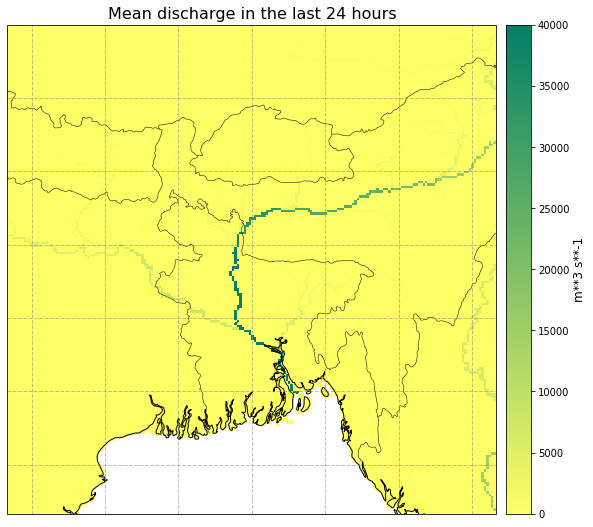

In [17]:
mean_data = glofas_data.dis24.mean(dim='time')
mean_data = mean_data.assign_attrs(**glofas_data.dis24.attrs)
plot_map(
    mean_data,
    vmax=40e3, vmin=0
)

<br>

#### Accessing the upstream area data
The upstream area denotes the total upstream area for each river pixel, expressed in m2. It is defined as the catchment area for each river segment. For more information, see the [CEMS-Floods auxiliary data 
page](https://confluence.ecmwf.int/display/CEMS/Auxiliary+Data).

For Version 4.0, we would suggest the river discharge data is only used in places where the upstream area is >= 250km2. So, let's apply that threshold to the river discharge data now.

In [11]:
#download and open the upstream area file
upstream_area_file = f"{DATADIR}/uparea_glofas_v4_0.nc"
u_version=2
upstream_data_url = f"https://confluence.ecmwf.int/download/attachments/242067380/{upstream_area_file}?version={u_version}&modificationDate=1668604690076&api=v2&download=true"
if not os.path.isfile(upstream_area_file):
   os.system(f"wget -q {upstream_data_url}")
   os.rename(f"{upstream_area_file}?version={u_version}", upstream_area_file)
upstream_area = xr.open_dataset(upstream_area_file)
upstream_area.uparea

<xarray.DataArray 'uparea' (latitude: 3000, longitude: 7200)>
[21600000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * latitude   (latitude) float64 89.97 89.92 89.88 ... -59.88 -59.92 -59.97
Attributes:
    long_name:  Upstream area of each river pixel
    units:      m2
    lon:        longitude
    lat:        latitude

In [12]:
# Reduce the Upstream area data to the domain of the river discharge

# Get the latitude and longitude limits of the data
lat_limits = [glofas_data.latitude.values[i] for i in [0, -1]]
lon_limits = [glofas_data.longitude.values[i] for i in [0, -1]]
up_lats = upstream_area.latitude.values.tolist()
up_lons = upstream_area.longitude.values.tolist()

lat_slice_index = [
    round((i-up_lats[0])/(up_lats[1]-up_lats[0]))
    for i in lat_limits
]
lon_slice_index = [
    round((i-up_lons[0])/(up_lons[1]-up_lons[0]))
    for i in lon_limits
]

# Slice upstream area to bangladesh region:
red_upstream_area = upstream_area.isel(
    latitude=slice(lat_slice_index[0], lat_slice_index[1]+1),
    longitude=slice(lon_slice_index[0], lon_slice_index[1]+1),
)

# There are very minor rounding differences, so we update with the lat/lons from the glofas data
red_upstream_area = red_upstream_area.assign_coords({
    'latitude': glofas_data.latitude,
    'longitude': glofas_data.longitude,
})
glofas_data['uparea'] = red_upstream_area['uparea']
glofas_data

<xarray.Dataset>
Dimensions:     (time: 330, latitude: 202, longitude: 202)
Coordinates:
  * time        (time) datetime64[ns] 2012-06-01 2012-06-02 ... 2022-06-30
    step        timedelta64[ns] 1 days
    surface     float64 0.0
  * latitude    (latitude) float64 30.02 29.97 29.92 29.87 ... 20.07 20.02 19.97
  * longitude   (longitude) float64 84.97 85.02 85.07 ... 94.92 94.97 95.02
    valid_time  (time) datetime64[ns] 2012-06-02 2012-06-03 ... 2022-07-01
Data variables:
    dis24       (time, latitude, longitude) float32 ...
    uparea      (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-02-08T09:15 GRIB to CDM+CF via cfgrib-0.9.9...

<br>

### Apply the upstream area threshold to the discharge data

We now mask the river discharge data to where the upstream area is >= 250km2, and plot it to see how it looks

/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


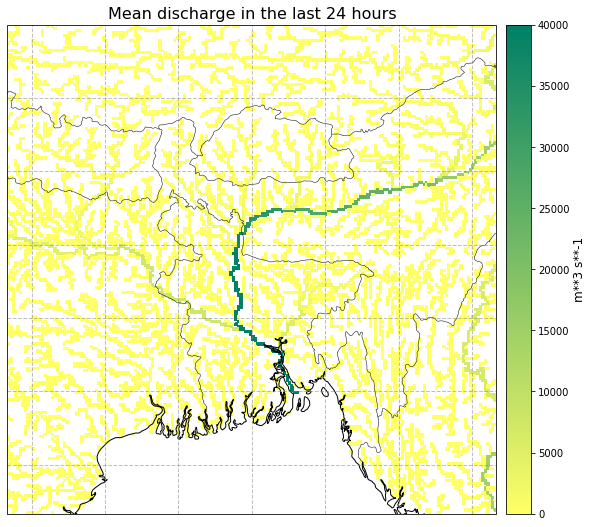

In [18]:
glofas_data_masked = glofas_data.where(glofas_data.uparea>=250.e6)
mean_masked_data = glofas_data_masked.dis24.mean(dim='time').assign_attrs(glofas_data_masked.dis24.attrs)
plot_map(
    mean_masked_data,
    vmax=40e3, vmin=0
)

#### Calculating the climatology
First, let's see how severe these 2022 floods were for the area as a whole, when compared to 2012-2021 data.

In [92]:
# select the 2012-2021 data
glofas_historical_dates = glofas_data_masked.sel(time=slice("2012","2021"))

# calculate the mean discharge over the whole domain, for each day in June
glofas_xy_climatology = glofas_historical_dates.dis24.mean(["longitude", "latitude"]).groupby('time.day').mean("time")

# calculate the minimum and maximum discharge over the whole domain, for each day in June
glofas_xy_clim_min = glofas_historical_dates.dis24.mean(["longitude", "latitude"]).groupby('time.day').min("time")
glofas_xy_clim_max = glofas_historical_dates.dis24.mean(["longitude", "latitude"]).groupby('time.day').max("time")
# Calculate the 10th and 90th percentiles of discharge rate of the whole domain
glofas_xy_clim_quantiles = glofas_historical_dates.dis24.mean(
    ["longitude", "latitude"]
).groupby('time.day').quantile(dim="time", q=[0.1,0.9])

# calculate the mean discharge over the whole domain for each day in June 2022
glofas_xy_2022 = glofas_data_masked.dis24.sel(time="2022")
glofas_xy_2022_mean = glofas_xy_2022.mean(['longitude','latitude']).groupby('time.day').mean("time")

<br>


Now let's plot the data..

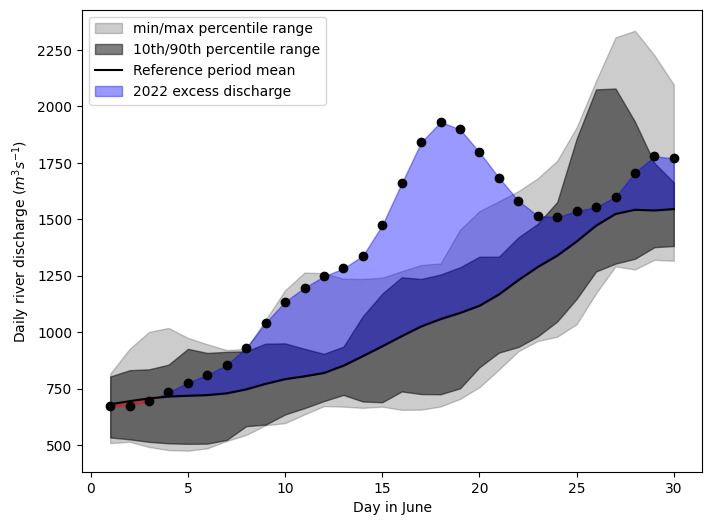

In [99]:
from statistics import quantiles


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()

ax.fill_between(
    np.arange(1, 31), glofas_xy_clim_min.values, glofas_xy_clim_max.values,
    color="k", alpha=0.2, label='min/max percentile range'
)

ax.fill_between(
    np.arange(1, 31),
    glofas_xy_clim_quantiles.isel(quantile=0).values,
    glofas_xy_clim_quantiles.isel(quantile=1).values,
    color="k", alpha=0.5, label='10th/90th percentile range'
)

(line_base,) = plt.plot(
    np.arange(1, 31), glofas_xy_climatology.values, color="k", label="Reference period mean"
)

ax.fill_between(
    range(1, int(glofas_xy_2022_mean.shape[0]) + 1),
    glofas_xy_climatology.values[: int(glofas_xy_2022_mean.shape[0])],
    glofas_xy_2022_mean.values,
    color="b",
    alpha=0.4,
    where=glofas_xy_2022_mean.values >= glofas_xy_climatology.values[: int(glofas_xy_2022_mean.shape[0])],
    interpolate=True, label="2022 excess discharge"
)

ax.fill_between(
    range(1, int(glofas_xy_2022_mean.shape[0]) + 1),
    glofas_xy_climatology.values[: int(glofas_xy_2022_mean.shape[0])],
    glofas_xy_2022_mean.values,
    color="r",
    alpha=0.4,
    where=glofas_xy_2022_mean.values < glofas_xy_climatology.values[: int(glofas_xy_2022_mean.shape[0])],
    interpolate=True,
)

dots = ax.scatter(
    range(1, int(glofas_xy_2022_mean.shape[0]) + 1),
    glofas_xy_2022_mean.values,
    color="k",
    # label="2022",
    zorder=2,
)
ax.legend(loc='upper left')
plt.xlabel("Day in June")
plt.ylabel("Daily river discharge ($m^{3}s^{-1}$)")
plt.show()

From this plot, we see that around the 8th of June river discharge in 2022 began to exceed the 90th percentile, and by the 13th was exceeding the 10-year historical maximum.

However, this plot doesn't give us an idea of how the severity of the flooding varied spatially, so let's have a look at that.

In [19]:
# Calculate the climatology
glofas_climatology = glofas_data_masked.groupby('time.dayofyear').mean("time")
glofas_climat_quantiles = glofas_data_masked.groupby('time.dayofyear').quantile(dim="time", q=[0.1,0.5,0.9])

# # Calculate the anomaly w.r.t the above climatology
# glofas_anomaly = glofas_data_masked.groupby('time.dayofyear') - glofas_climatology
# # Calculate this a relative anomaly
# glofas_relanom = glofas_anomaly.groupby('time.dayofyear')/glofas_climatology

glofas_high = glofas_data_masked.groupby('time.dayofyear') > glofas_climat_quantiles.sel(quantile=0.9)
glofas_high = glofas_high.where(glofas_data.uparea>250e6)


/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/cartopy/mpl/style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


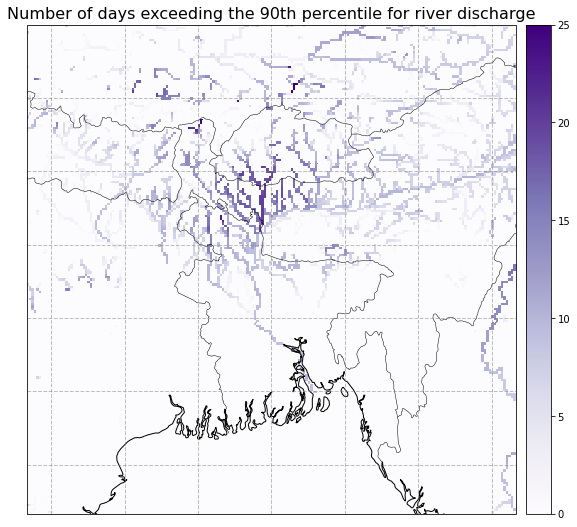

In [23]:
# Plot the data:
year='2022'
number_of_high_days = glofas_high.sel(time=year).dis24.sum(dim='time')
number_of_high_days = number_of_high_days.assign_attrs(glofas_high.dis24.attrs)
plot_map(
    number_of_high_days, vmax=25, cmap='Purples', title='Number of days exceeding the 90th percentile for river discharge'
)

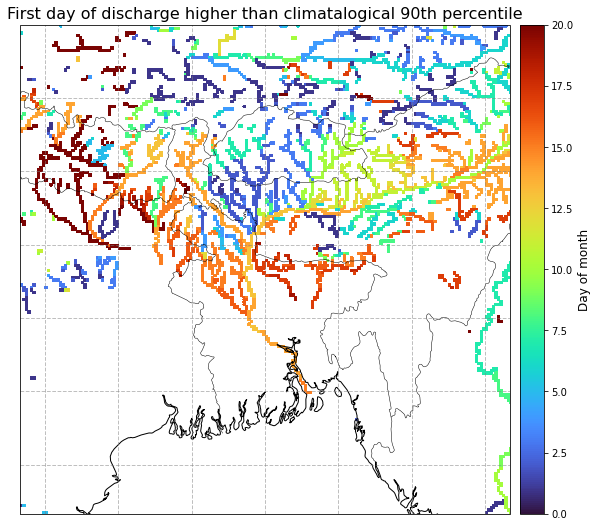

In [24]:
year='2022'
glofas_high_this_year = glofas_high.sel(time=year)

first_high_day = np.zeros_like(number_of_high_days)
for i in range(30):
    this_high_day = i*glofas_high_this_year.isel(time=i)
    first_high_day[first_high_day==0] = this_high_day.dis24.values[first_high_day==0]
first_high_day[first_high_day==0] = np.nan
first_high_day = xr.DataArray(
    first_high_day,
    name='first_day_of_high_discharge',
    dims = number_of_high_days.dims,
    coords=number_of_high_days.coords,
    attrs={
        'units': 'Day of month',
        'long_name': 'First day of discharge higher than climatalogical 90th percentile'
    }
)

plot_map(first_high_day, cmap='turbo', vmin=0, vmax=20)


In [22]:
first_high_day

<xarray.DataArray 'first_day_of_high_discharge' (latitude: 202, longitude: 202)>
array([[nan, nan, nan, ...,  3.,  3.,  3.],
       [nan, nan, nan, ...,  3., nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, 10., nan],
       [nan, nan, nan, ..., nan, nan, 10.],
       [nan, nan, nan, ..., nan, nan, 10.]])
Coordinates:
    step       timedelta64[ns] 1 days
    surface    float64 0.0
  * latitude   (latitude) float64 30.02 29.97 29.92 29.87 ... 20.07 20.02 19.97
  * longitude  (longitude) float64 84.97 85.02 85.07 85.12 ... 94.92 94.97 95.02
    quantile   float64 0.9
Attributes:
    units:      Day of month
    long_name:  First day of discharge higher then climatalogical 90th percen...